In [1]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
print(f"pfp_api_client: {pfp_api_client.__version__}")
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy

import ase.io
import ase.calculators.singlepoint


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)

pfp_api_client: 1.8.0


In [2]:
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter


def get_opt_energy(atoms, fmax=0.001, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

In [3]:
def aseify_reactions(reactions):
    for i, reaction in enumerate(reactions):
        for j, _ in enumerate(reactions[i]['reactionSystems']):
            with io.StringIO() as tmp_file:
                system = reactions[i]['reactionSystems'][j].pop('systems')
                tmp_file.write(system.pop('InputFile'))
                tmp_file.seek(0)
                atoms = ase.io.read(tmp_file, format='json')
            calculator = ase.calculators.singlepoint.SinglePointCalculator(
                atoms,
                energy=system.pop('energy')
            )
            atoms.set_calculator(calculator)
            #print(atoms.get_potential_energy())
            reactions[i]['reactionSystems'][j]['atoms'] = atoms
        # flatten list further into {name: atoms, ...} dictionary
        reactions[i]['reactionSystems'] = {x['name']: x['atoms']
                                          for x in reactions[i]['reactionSystems']}

#AraComputational2022

In [4]:
import os
path_json = os.path.join(os.getcwd(), "AraComputational2022.json")
with open(path_json, 'r') as f:
  data = json.load(f)
dat=data['raw_reactions']
dat = copy.deepcopy(dat)
aseify_reactions(dat)

real_E=[dat[i]['reactionEnergy'] for i in range(0,len(dat))]
print(real_E)
print(len(real_E))

[-1.2648176999999805, -0.022518445000002885, -3.2535839450000026, 0.11679257999998072, 1.7966659549999804, -1.388406635000024, 2.382700580000005, 3.370456474999969, 0.43289394499998934, 1.1876553000000172, 3.1447863049999683, 0.06664692499998637, 0.5387292300000013, 1.3560603149999793, -1.9202152949999913, -1.5435000599999853, -0.8264305550000017, -0.10121466499998633, -0.661365260000025, 1.296579784999949, -2.2973821850000036, 0.7042213199999878, 1.6557347849999928, -1.6239503450000257, -2.2498044599999503, -2.9154926149999483, -3.070856054999979, 2.546224460000019, 3.05456243499998, -0.3098709750000239, 0.15881024000003663, 1.275831715000038, -1.9331100150000111, -0.7350066399999946, 2.8495105650000028, -0.45215506499999947, -2.155776249999974, 0.6036638450000282, -3.135916655000017, 1.3742644999999811, 3.3605011949999835, 0.30315172500002063, -0.8467939199999819, 0.7659662249999997, -2.2651423149999914, 3.9052829199999906, 4.501033755000037, 1.6596142249999843, 2.2148694800000044, 3

real_E saves reference E

In [5]:
estimator2 = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator2)

from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter

def energy_cal(atoms, fmax=0.001, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

In [6]:
dat[5]

{'Equation': 'H2O(g) - 0.5H2(g) + * -> HO*',
 'reactants': '{"star": 1, "H2gas": -0.5, "H2Ogas": 1}',
 'products': '{"HOstar": 1}',
 'reactionEnergy': -1.388406635000024,
 'reactionSystems': {'H2gas': Atoms(symbols='H2', pbc=True, cell=[20.0, 20.0, 20.0], calculator=SinglePointCalculator(...)),
  'HOstar': Atoms(symbols='YPO3C44OH', pbc=True, cell=[[10.692686, 6.168836, 0.0], [-10.692686, 6.168835, 0.0], [0.0, 0.0, 19.997996]], calculator=SinglePointCalculator(...)),
  'H2Ogas': Atoms(symbols='OH2', pbc=True, cell=[20.0, 20.0, 20.0], calculator=SinglePointCalculator(...)),
  'star': Atoms(symbols='YPO3C44', pbc=True, cell=[[10.692685673, 6.168835679, 3e-09], [-10.692685549, 6.168835464, -5e-09], [7e-09, -3e-09, 19.997996094]], calculator=SinglePointCalculator(...))}}

In [7]:
import json
def stoich(data,i):
    data_string =data[i]['reactants']
    prod_string =data[i]['products']
    reactants_list = list(json.loads(data_string).keys())
    values_list = list(json.loads(data_string).values())
    product = list(json.loads(prod_string).keys())
    return values_list, reactants_list, product

In [8]:
def pfp_calculator(data,fmax_ref):
 E_ads_list=[]
 for i in range (0, len(data)):
    print('<<<<<<<<<<<<<<<<<<<',i+1,' out of ',len(data) ,'>>>>>>>>>>>>>>>>>>>>')
    sto, reactants, prod = stoich(data,i)
    if len(reactants)==2:
        E_tot=energy_cal(data[i]['reactionSystems'][prod[0]] , fmax=fmax_ref)
        E_ref1=energy_cal(data[i]['reactionSystems'][reactants[0]], fmax=fmax_ref)
        E_ref2=energy_cal(data[i]['reactionSystems'][reactants[1]], fmax=fmax_ref)
        E_ads=E_tot-E_ref1*sto[0]-E_ref2*sto[1]
        E_ads_list.append(E_ads)    
    elif len(reactants)==3:
        E_tot=energy_cal(data[i]['reactionSystems'][prod[0]] , fmax=fmax_ref)
        E_ref1=energy_cal(data[i]['reactionSystems'][reactants[0]], fmax=fmax_ref)
        E_ref2=energy_cal(data[i]['reactionSystems'][reactants[1]], fmax=fmax_ref)
        E_ref3=energy_cal(data[i]['reactionSystems'][reactants[2]], fmax=fmax_ref)
        E_ads=E_tot-E_ref1*sto[0]-E_ref2*sto[1]-E_ref3*sto[2]
        E_ads_list.append(E_ads)
    else:
        E_tot=energy_cal(data[i]['reactionSystems'][prod[0]] , fmax=fmax_ref)
        E_ref1=energy_cal(data[i]['reactionSystems'][reactants[0]], fmax=fmax_ref)
        E_ref2=energy_cal(data[i]['reactionSystems'][reactants[1]], fmax=fmax_ref)
        E_ref3=energy_cal(data[i]['reactionSystems'][reactants[2]], fmax=fmax_ref)
        E_ref4=energy_cal(data[i]['reactionSystems'][reactants[3]], fmax=fmax_ref)
        E_ads=E_tot-E_ref1*sto[0]-E_ref2*sto[1]-E_ref3*sto[2]-E_ref4*sto[3]
        E_ads_list.append(E_ads)
    proceed=round((i+1)/len(data)*100,2)
    print(status(proceed),proceed,'% done')
 return E_ads_list
def status(proceed):    
    num = int(proceed/5)  
    return '🟩'*num+'⬜️'*(20-num)



In [13]:
pfp_E_0p1=pfp_calculator(dat,0.1)

<<<<<<<<<<<<<<<<<<< 1  out of  192 >>>>>>>>>>>>>>>>>>>>
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:28:26     -374.879226*       0.0691
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:28:26     -368.147342*       0.0958
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:28:26       -4.532473*       0.0285
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:28:26      -10.076618*       0.0780
⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️ 0.52 % done
<<<<<<<<<<<<<<<<<<< 2  out of  192 >>>>>>>>>>>>>>>>>>>>
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 05:28:26     -381.303934*       0.0796
       Step     Time          Energy         fmax
*Force-consistent energies used in 

In [14]:
print(pfp_E_0p1)

[-1.1877390445727922, 0.19792798152074553, -3.181715122778419, -0.29689858797362767, -0.6103275654303566, -2.0046367667679217, 2.662302930312906, 3.6472502220311576, 0.6762023082482731, 1.3793379372196188, 3.311010360840367, 0.1312989789252672, 0.3679950582399858, 1.3488198418470283, -2.0052300241744003, -1.315457688069186, -0.6644001079618143, 0.29945436276654824, -0.6439240067568601, 1.2584444523945244, -2.3272463797455227, 0.6913487525560829, 1.655444589800691, -1.7123452312079532, -2.2216280396937957, -2.759701502645459, -3.1361332770633705, 2.711559362417036, 3.202240546300498, -0.19420022542737136, -0.13083334416935877, 1.1679552383571767, -2.210367702800843, -0.7368291214471849, 3.1371204560310666, 0.02807631117515008, -2.055702244282683, 0.6685259724212465, -3.077158295390566, 1.7452014253284194, 3.6066996780546496, 0.6685516309239095, -1.1165957548034537, 0.7238962559908195, -2.470574582976374, 3.7527761071424113, 4.539114750826609, 1.622865545227123, 2.277740237868871, 3.8718

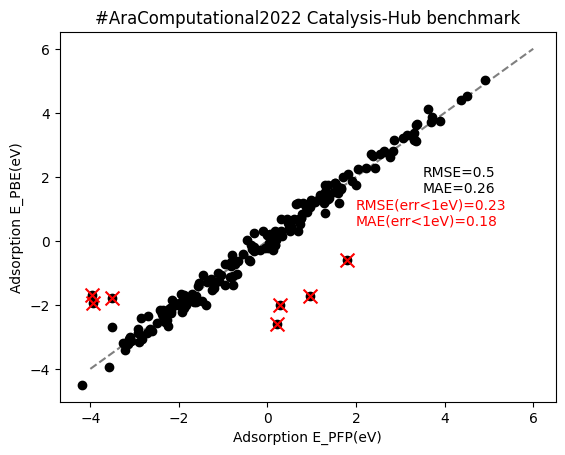

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def err_est(pfp_E):
    rms = mean_squared_error(real_E, pfp_E, squared=False)
    mae=mean_absolute_error(real_E, pfp_E)
    rms_str='RMSE='+str(round(rms,2))
    mae_str='MAE='+str(round(mae,2))
    err=[]
    err=[rms_str,mae_str]
    return err
def err_est_wo_outlier(pfp_E):
    temp=[]
    real_temp=[]
    real_out =[]
    pfp_out =[]
    out=[]
    for i in range(0,len(pfp_E)):
     if abs(real_E[i]-pfp_E[i])<1:
        temp.append(pfp_E[i])
        real_temp.append(real_E[i])
     else:
        pfp_out.append(pfp_E[i])
        real_out.append(real_E[i])
        out.append(i)
    rms = mean_squared_error(real_temp, temp, squared=False)
    mae=mean_absolute_error(real_temp, temp)
    rms_str='RMSE(err<1eV)='+str(round(rms,2))
    mae_str='MAE(err<1eV)='+str(round(mae,2))
    err=[]
    err=[rms_str,mae_str]
    return err, real_out, pfp_out, out

err2, real_out, pfp_out, out =err_est_wo_outlier(pfp_E_0p1)
err1=err_est(pfp_E_0p1)
plt.plot([-4,-1,0,1, 2, 3,6],[-4,-1,0,1, 2, 3,6],'--',color='black',alpha=0.5)
plt.text(3.5,2,err1[0])
plt.text(3.5,1.5,err1[1])
plt.text(2,1,err2[0],color='red')
plt.text(2,0.5,err2[1],color='red')
plt.scatter(real_E,pfp_E_0p1,color='black')
plt.scatter(real_out,pfp_out,color='red',marker='x', s = 100 )
plt.title('#AraComputational2022 Catalysis-Hub benchmark')
plt.xlabel('Adsorption E_PFP(eV)')
plt.ylabel('Adsorption E_PBE(eV)')
plt.show()

YPO₃C₄₄_Error(eV)=2.41eV


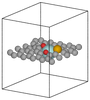

HfBN₃C₄₄_Error(eV)=2.69eV


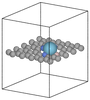

HfSN₃C₄₄_Error(eV)=2.79eV


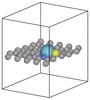

ScNO₃C₄₄_Error(eV)=2.29eV


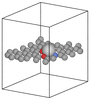

VSN₃C₄₄_Error(eV)=2.01eV


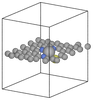

VSN₃C₄₄_Error(eV)=1.72eV


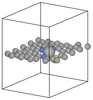

VSN₃C₄₄_Error(eV)=2.27eV


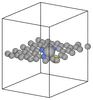

In [35]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pfcc_extras.visualize.ase import view_ase_atoms
from ase.io.vasp import read_vasp
from ase.io import Trajectory
from PIL import Image
from IPython.display import display
subscript = str.maketrans("0123456789-_", "₀₁₂₃₄₅₆₇₈₉→→")
def render_and_display(nano,filename, max_size=(300, 300)):
    renderer = write('./'+filename+'.pov', nano, rotation='10z,-60x')
    renderer.render()
    image_path = './'+filename+'.png'
    img = Image.open(image_path)
    img.thumbnail(max_size, Image.LANCZOS)
    display(img)
    
for i in range(0,len(out)):
    slab=dat[out[i]]['reactionSystems']['star']
    name=str(dat[out[i]]['reactionSystems']['star'].symbols).translate(subscript)
    titles =str(name)+'_Error(eV)='+str(round(abs(real_out[i]-pfp_out[i]),2))+'eV'
    print(titles)
    render_and_display(slab,'hi',(100,100))

In [ ]:
def err_est_wo_outlier(pfp_E):
    temp=[]
    real_temp=[]
    for i in range(0,len(pfp_E)):
     if abs(real_E[i]-pfp_E[i])<1:
        temp.append(pfp_E[i])
        real_temp.append(real_E[i])
    rms = mean_squared_error(real_temp, temp, squared=False)
    mae=mean_absolute_error(real_temp, temp)
    rms_str='RMSE='+str(round(rms,2))
    mae_str='MAE='+str(round(mae,2))
    err=[]
    err=[rms_str,mae_str]
    return err
err1=err_est_wo_outlier(pfp_E_0p1)
print(err1[0])
print(err1[1])